# Valuatoin for Airbnb units in New Orlean

Objective: set the competitive **daily accomodation rate** for a Sonder unit in downtown **central business district**.



The owner currently charges $70. The task is to estimate a **fair value** that Sonder should be charging. The unit has the following characteristics and constraints. 

1. The owner has been a host since **August 2015**
1. The location is in downtown central business district **(-90.075, 29.95)**
1. The current review score rating **95.0**
1. Number of reviews **70**
1. Minimum nights **1**
1. The house can accomodate **2** people.
1. The owner currently charges a cleaning fee of **50**
1. The house has **1 bathrooms, 1 bedroom, 1 beds**.
1. The house is available for **255 of the next 365 days**
1. The client is **verified**, and he is a **superhost**.
1. The cancelation policy is **strict with a 14 days grace period**.
1. The host requires security deposit of **400**

In [803]:
client_unit = {}

client_unit['house_rules'] = """House Rules 1. Reservations require a $400 security deposit that is not charged in advance. 
                                            2. Guests can cancel free of charge within 24 hours of booking (please contact us to process the refund). You will be charged 50% of the booking price (minus the service fee) if you cancel more than seven days before arrival, and 100% of the total price if you cancel within seven days of arrival. 
                                            3. Check-in is at 4 pm. Checkout is at 11 am. Early check-in or late checkout may be available upon request. Guests who stay beyond their designated checkout time or delay our housekeeping staff are liable for any associated costs and expenses. 
                                            4. Typically, we do not allow guests to book in their city of residence. We will review all reservations made in a guestâ€™s home city and allow exceptions under special circumstances. 
                                            5. Smoking, parties, and excessive noise are not allowed, including on balconies and in shared spaces. Smoking violations are subject to a $250 fine plus the cost to clean, deodorize, 
                             """
client_unit['host_response_time'] = 'within an hour'
client_unit['host_acceptance_rate'] = 89.0
client_unit['host_is_superhost'] = 1
client_unit['neighbourhood'] ='Central Business District'
client_unit['latitude'] = 29.95
client_unit['longitude'] = -90.075
client_unit['property_type'] = 'Apartment'
client_unit['room_type'] = 'Entire home/apt'

client_unit['accommodates'] = 2
client_unit['bathrooms'] = 1 
client_unit['bedrooms'] = 1
client_unit['beds'] = 1
client_unit['amenities'] = '{TV,"Cable TV",Wifi,"Air conditioning",Pool,Kitchen,Gym,Elevator,Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Keypad,"Private living room","Hot water","Bed linens",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"BBQ grill","Long term stays allowed"}'
client_unit['bed_type'] = 'Real Bed'
client_unit['price'] = 150
client_unit['security_deposit'] = 400
client_unit['cleaning_fee'] = 50
client_unit['guests_included'] = 2
client_unit['minimum_nights'] = 1
client_unit['availability_365'] = 255
client_unit['number_of_reviews'] = 70
client_unit['review_scores_rating'] = 95
client_unit['cancellation_policy'] ='strict with a 14 days grace period.'
client_unit['reviews_per_month'] = 1.49

In [623]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#### Data preprocessing

In [569]:
def Str_to_int(x):
    if type(x) == str:
        return int(x.split('%')[0])
    else:
        return np.nan

In [570]:
stop_words = set(stopwords.words('english')) 
punct = set(string.punctuation)

def text_cleaning(text):
    text = re.sub(r'(?:[\ufffd]+)','',text) #removing special characters
    text = ''.join(word for word in text if word not in punct) #remove punctuation
    text = re.sub('\n','',text) #remove new line
    text = re.sub('@','',text) #remove @ sign
    text = text.lower() # lowercase all characters
    text = word_tokenize(text) # tonkenize words
    text = [i for i in text if not i in stop_words] #remove stop words
    text = ' '.join(text)
    return text

In [804]:
file_path = 'NOLA_airbnb_data/'
listing_fname = 'listings.csv.gz'

listing = file_path+listing_fname
file = pd.read_csv(listing,compression='gzip')

selected_columns = [ 'house_rules','host_response_time',
                     'host_acceptance_rate', 'host_is_superhost',
                     'neighbourhood','latitude','longitude',
                     'property_type','room_type',
                     'accommodates','bathrooms', 'bedrooms', 'beds',
                     'amenities','bed_type','price',
                     'security_deposit', 'cleaning_fee', 'guests_included',
                     'minimum_nights', 'availability_365',
                     'number_of_reviews', 'review_scores_rating',
                     'cancellation_policy','reviews_per_month']

df = file[selected_columns]

df = df[df['neighbourhood'].isin(['Central Business District',
                                  'Central Business District/Warehouse District',
                                  'Central City'])]
df.reset_index(drop = True, inplace = True)

df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: Str_to_int(x))

In [805]:
df['house_rules'] = df['house_rules'].fillna('none')
df['security_deposit'] = df['security_deposit'].fillna('0')
df['cleaning_fee'] = df['cleaning_fee'].fillna('0')
df['beds'] = df['beds'].fillna(df['beds'].median())
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(value = df['host_acceptance_rate'].median())
df['host_response_time'] = df['host_response_time'].fillna(value = df['host_response_time'].mode()[0])
df['review_scores_rating'] = df['review_scores_rating'].fillna(value = df['review_scores_rating'].mean())
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

dollar_col = ['price','security_deposit','cleaning_fee']

for col in dollar_col:
    df[col] = df[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

df['house_rules'] = df['house_rules'].apply(lambda x: text_cleaning(x))

super_host_map = {'t':int(1), 'f':int(0)}

encoder = OneHotEncoder()
df['host_is_superhost'] = df['host_is_superhost'].map(super_host_map)


""" 
Remove listing where

it has 0 bedrooms

it has 0 bathrooms

it has 0 beds

it has $ 0
"""

df = df[df['bedrooms'] != 0]
df = df[df['bathrooms'] != 0]
df = df[df['beds'] != 0]
df = df[df['price'] !=0]
df = df.reset_index(drop = True)

### Data exploratory analysis

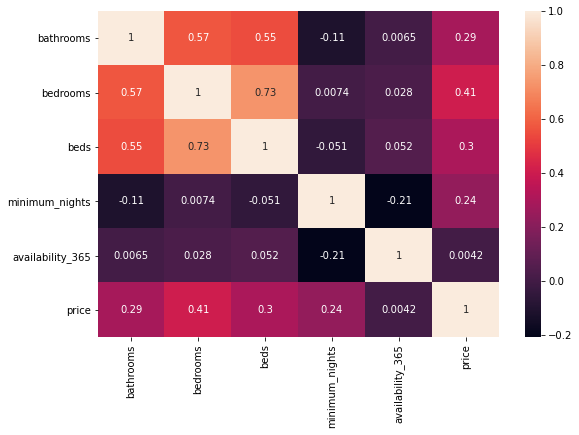

In [594]:
attribute_cols = ['bathrooms', 'bedrooms', 'beds','minimum_nights', 'availability_365','price']
attribute_corr = df[attribute_cols].corr()

fig, ax = plt.subplots(1,1,figsize = (9,6))
sns.heatmap(attribute_corr,annot = True, ax = ax)

Text(0.5, 1.0, 'non-superhost')

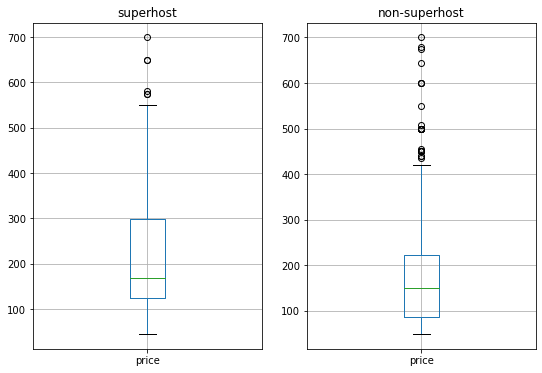

In [622]:
super_host = df[df['host_is_superhost'] == 1]
non_super_host = df[df['host_is_superhost'] == 0]

plt.figure(figsize = (9,6))
plt.subplot(1,2,1)
super_host.boxplot(column='price')
plt.title('superhost')
plt.subplot(1,2,2)
non_super_host.boxplot(column='price')
plt.title('non-superhost')

#### price, security deposity, minimum nights transformation

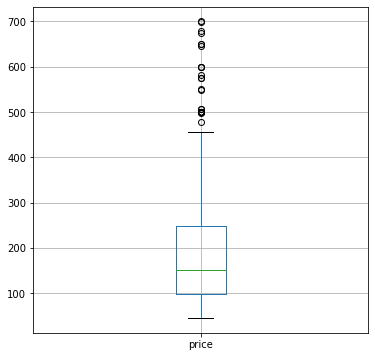

In [580]:
plt.figure(figsize = (6,6))
df.boxplot(column='price')

The boxplot shows that there are quite a few outliers, the best way is to exclude them in this case 

In [806]:
quantile_25 = df['price'].quantile(0.25)
quantile_75 = df['price'].quantile(0.75)
IQR = quantile_75 - quantile_25
df = df[df['price'] < (quantile_75+1.5*IQR)]
df.reset_index(drop=True, inplace = True)

quantile_25 = df['security_deposit'].quantile(0.25)
quantile_75 = df['security_deposit'].quantile(0.75)
IQR = quantile_75 - quantile_25
df = df[df['security_deposit'] < (quantile_75+1.5*IQR)]
df.reset_index(drop=True, inplace = True)

quantile_25 = df['minimum_nights'].quantile(0.25)
quantile_75 = df['minimum_nights'].quantile(0.75)
IQR = quantile_75 - quantile_25
df = df[df['minimum_nights'] < (quantile_75+1.5*IQR)]
df.reset_index(drop=True, inplace = True)

#### geo-map

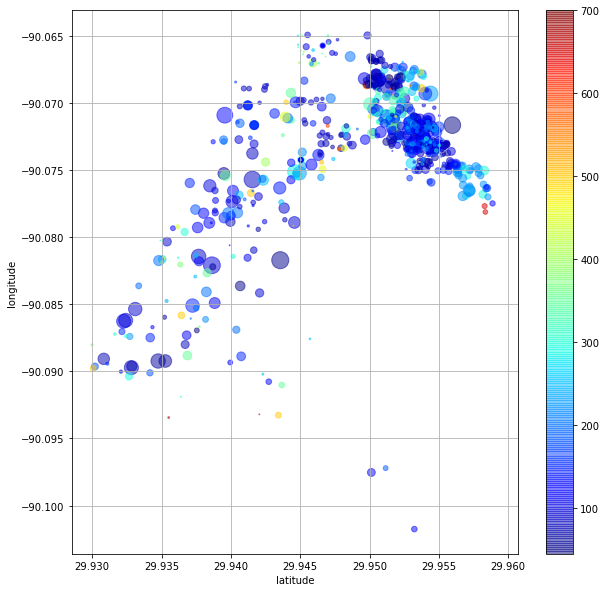

In [807]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df.plot('latitude','longitude',
        s = df['number_of_reviews'],
         c = df['price'], cmap=plt.get_cmap("jet"), colorbar=True, 
         alpha = 0.5,
         kind = 'scatter',ax = ax)
plt.grid()

#### categorical features transformation

In [808]:
catogorical_col = ['host_response_time','property_type',
                   'room_type','bed_type',
                   'cancellation_policy']

df_cat = df[catogorical_col]

In [809]:
# AMENITIES
amenities = list(df['amenities'])
total = ','.join(amenities)
total = total.replace("{", "").replace("}","").replace("\"", "").split(",")
amenity_items = list(set(total))
amenity_items = list(filter(None, amenity_items))
for item in amenity_items:
    if re.match(r'translation',item):
        amenity_items.remove(item)

ammenity_table = pd.DataFrame(index = df.reset_index().values[:,0], columns = amenity_items).fillna(0)

for i in range(len(amenities)):
    for item in amenity_items:
        if item in amenities[i]:
            ammenity_table[item][i] = 1

sum_table = np.array(ammenity_table.sum())
idx = (-sum_table).argsort()[:60]
common_amenities = list(ammenity_table.sum().iloc[idx].index)
#df_cat = df_cat.drop(['amenities'], axis = 1)
df_cat = pd.get_dummies(df_cat,drop_first=True)
df_cat = pd.concat([df_cat, ammenity_table[common_amenities]], axis = 1)

In [882]:
num_col = ['host_acceptance_rate','beds', 
           'security_deposit','cleaning_fee', 
           'guests_included', 'minimum_nights', 'availability_365',
           'number_of_reviews', 'review_scores_rating','reviews_per_month' ]

df_num = df[num_col]

df_to_cluster = pd.concat([df_num,df_cat], axis = 1)

### clustering

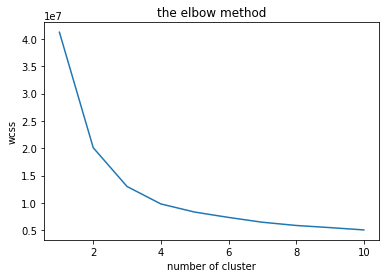

In [884]:
wcss =[]
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init ='k-means++', max_iter =300, n_init =10, random_state = 0)
    kmeans.fit(df_to_cluster.values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('the elbow method')
plt.xlabel('number of cluster')
plt.ylabel('wcss')
plt.show()

In [885]:
kmeans = KMeans(n_clusters = 4, init ='k-means++', max_iter =300, n_init =10, random_state = 0)
clusters = kmeans.fit_predict(df_to_cluster.values)

df_clustered = df.copy()
df_clustered['cluster'] = clusters

group_0 = df_clustered[df_clustered['cluster'] == 0]
group_0.reset_index(drop=True,inplace=True)
group_1 = df_clustered[df_clustered['cluster'] == 1]
group_1.reset_index(drop=True,inplace=True)
group_2 = df_clustered[df_clustered['cluster'] == 2]
group_2.reset_index(drop=True,inplace=True)
group_3 = df_clustered[df_clustered['cluster'] == 3]
group_3.reset_index(drop=True,inplace=True)

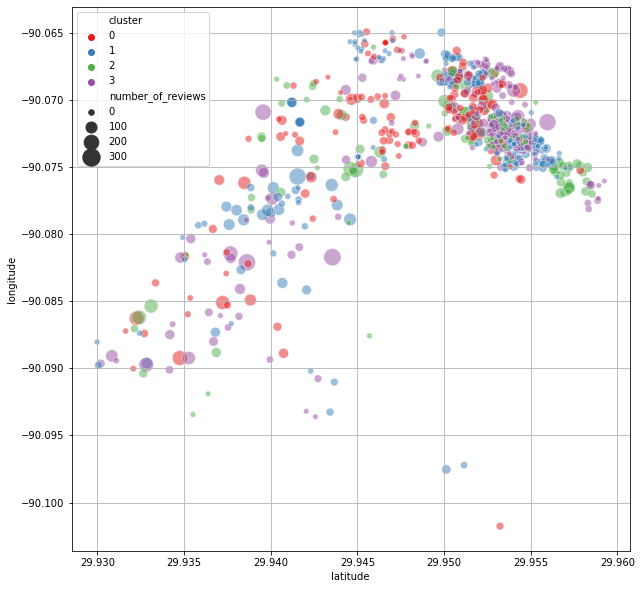

In [886]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax = sns.scatterplot(x='latitude', y='longitude', 
                     hue='cluster', size ='number_of_reviews',
                     alpha = 0.5,
                     sizes=(30, 300),
                     data=df_clustered,
                     palette = 'Set1')
plt.grid()

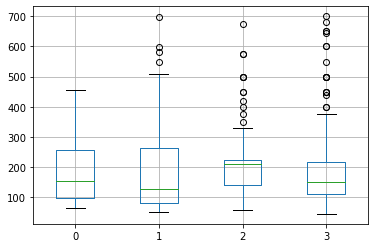

In [887]:
clusters_price = pd.concat([group_0['price'], group_1['price'], group_2['price'],group_3['price']],
                           axis =1, ignore_index= True)
clusters_price.boxplot()

### PCA

In [930]:
num_col = ['host_acceptance_rate','beds', 
           'security_deposit','cleaning_fee', 
           'guests_included', 'minimum_nights', 'availability_365',
           'number_of_reviews', 'review_scores_rating','reviews_per_month' ]

df_num = df[num_col]

sc = MinMaxScaler()
df_num_sc = pd.DataFrame(sc.fit_transform(df_num),columns = df_num.columns)

df_final = pd.concat([df_num_sc,df_cat,df['price']], axis = 1)
df_final['cluster'] = clusters

cluster_0 = df_final[df_final['cluster'] == 0]
cluster_0.reset_index(drop=True,inplace=True)

cluster_1 = df_final[df_final['cluster'] == 1]
cluster_1.reset_index(drop=True,inplace=True)

cluster_2 = df_final[df_final['cluster'] == 2]
cluster_2.reset_index(drop=True,inplace=True)

cluster_3 = df_final[df_final['cluster'] == 3]
cluster_3.reset_index(drop=True,inplace=True)

cluster_0.drop('cluster',axis = 1, inplace = True)
cluster_1.drop('cluster',axis = 1, inplace = True)
cluster_2.drop('cluster',axis = 1, inplace = True)
cluster_3.drop('cluster',axis = 1, inplace = True)

X_0 = cluster_0.iloc[:,:-1]
y_0 = cluster_0['price']


X_1 = cluster_1.iloc[:,:-1]
y_1 = cluster_1['price']

X_2 = cluster_2.iloc[:,:-1]
y_2 = cluster_2['price']

X_3 = cluster_2.iloc[:,:-1]
y_3 = cluster_2['price']

C:\Anaconda\envs\GJ\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0, 0.5, 'cumulative explained variance')

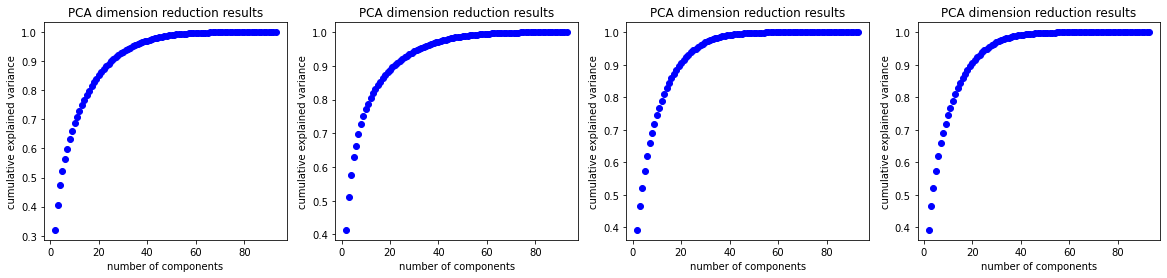

In [931]:
track_0 = []
track_1 = []
track_2 = []
track_3 = []
n = np.arange(2,94)


for n in n_components:
    n_component = min(n,len(X_0))
    pca = PCA(n_components = n_component)
    pca.fit_transform(X_0)
    explained_variance = pca.explained_variance_ratio_
    track_0.append(np.cumsum(explained_variance)[-1])

for n in n_components:
    n_component = min(n,len(X_1))
    pca = PCA(n_components = n_component)
    pca.fit_transform(X_1)
    explained_variance = pca.explained_variance_ratio_
    track_1.append(np.cumsum(explained_variance)[-1])


for n in n_components:
    n_component = min(n,len(X_2))
    pca = PCA(n_components=n_component)
    pca.fit_transform(X_2)
    explained_variance = pca.explained_variance_ratio_
    track_2.append(np.cumsum(explained_variance)[-1])

for n in n_components:
    n_component = min(n,len(X_3))
    pca = PCA(n_components=n_component)
    pca.fit_transform(X_3)
    explained_variance = pca.explained_variance_ratio_
    track_3.append(np.cumsum(explained_variance)[-1])


plt.figure(figsize = (20,4))
plt.subplot(1,4,1)
plt.plot(n_components,track_0,'bo')
plt.title('PCA dimension reduction results')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.subplot(1,4,2)
plt.plot(n_components,track_1,'bo')
plt.title('PCA dimension reduction results')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.subplot(1,4,3)
plt.plot(n_components,track_2,'bo')
plt.title('PCA dimension reduction results')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.subplot(1,4,4)
plt.plot(n_components,track_3,'bo')
plt.title('PCA dimension reduction results')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Model training

In [652]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [932]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_0.values, test_size =0.3, random_state =44)

RF_0 = RandomForestRegressor()

RF_0.fit(X_train,y_train)

forest_scores = cross_val_score(RF_0, X_pca, y_0,scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 74.5481212   77.26102733 117.84150972  89.41056691  91.9367673
 122.66767479  51.14539813  75.68254092  59.64669949 104.45542153]
Mean: 86.45957273111354
Standard deviation: 22.28693037006114


In [933]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_1.values, test_size =0.3, random_state =44)

RF_1 = RandomForestRegressor()

RF_1.fit(X_train,y_train)


forest_scores = cross_val_score(RF_1, X_pca, y_1,scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [132.81930827  26.98672316  44.05765666  66.96922101  93.73948631
  96.86086509   8.36746285  43.1704896   97.44088079 118.65942519]
Mean: 72.90715189201863
Standard deviation: 39.138582116449726


In [941]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2.values, test_size =0.3, random_state =44)

RF_2 = RandomForestRegressor()

RF_2.fit(X_train,y_train)

forest_scores = cross_val_score(RF_2, X_pca, y_2,scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 94.85993543 139.71580295  63.68117477  73.36597154  25.40327879
  13.06621725   2.2223921  131.48003618 125.77120259 147.44828128]
Mean: 81.70142928851679
Standard deviation: 51.83909515555631


In [935]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_2.values, test_size =0.3, random_state =44)

RF_3 = RandomForestRegressor()

RF_3.fit(X_train,y_train)

forest_scores = cross_val_score(RF_3, X_pca, y_3,scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 97.41264503 130.03202447  62.50467076  73.25605868  21.77388313
  11.79960225   2.05046499 137.42809633 122.47895422 145.47480767]
Mean: 80.42112075283579
Standard deviation: 51.63651879023673


### Client unit value prediction

In [943]:
df_client = pd.DataFrame.from_records(client_unit,index=[0])
df_client = df_client[df.columns.values]

client_cat = df_client[catogorical_col]

client_num = df_client[num_col]

#sc = StandardScaler()
#num_sc = sc.fit_transform(client_num.values)
#client_num_sc = pd.DataFrame(num_sc, columns = client_num.columns)

# AMENITIES
client_amenities = ','.join(list(df_client['amenities']))

client_amenities = client_amenities.replace("{", "").replace("}","").replace("\"", "").split(",")

ammenity_table = pd.DataFrame(index = df_client.reset_index().values[:,0], columns = amenity_items).fillna(0)

for item in client_amenities:
    if item in ammenity_table.columns.values:
        ammenity_table[item] = 1

sum_table = np.array(ammenity_table.sum())
idx = (-sum_table).argsort()[:60]
common_amenities = list(ammenity_table.sum().iloc[idx].index)
#df_cat = df_cat.drop(['amenities'], axis = 1)
client_cat = pd.get_dummies(client_cat,drop_first=True)
client_cat = pd.concat([client_cat, ammenity_table[common_amenities]], axis = 1)

client_record = pd.concat([client_num,client_cat], axis = 1)

client_final = pd.DataFrame(index = df_client.reset_index().values[:,0], columns = df_to_cluster.columns.values).fillna(0)

for col in client_record.columns:
    if col in client_final.columns:
        client_final[col] = client_record[col].values

In [944]:
client_cluster = kmeans.predict(client_final.values)

client_final[num_col] = pd.DataFrame(sc.transform(client_final[num_col].values),columns = num_col)

client_pred = RF_2.predict(client_final)

In [958]:
print("Client's unit belongs to cluster: ", client_cluster.item())
print("Client's unit is estimated to set a price as $", client_pred.item())

Client's unit belongs to cluster:  2
Client's unit is estimated to set a price as $ 184.65
